# Lab1 (5IR - 2024): Human Activity Recognition (HAR) - Supervised learning

**Group name:** Abdel & Amine

**Names:** Anka Soubaai , Hatibi 

**First names:** Abdelmajid , Amine 



In this project, we will try to predict 8 different human activities: 

1-Recumbent, 2-Sitting, 3-Standing, 4-Walking, 5-Biking, 6-Nordic Walking, 7-Cleaning_Aspirator or 8-Repassing 

using different sensors (accelerometer, gyroscope, magnetometer or temperature) placed at different points on the body (hand, torso and ankle).


For the accelerometer, gyroscope and magnetometer sensors, measurements in $ms^{-2}$, $rad/s$ and $\mu T$ respectively are taken on the 3-axes at a sampling rate of 100Hz. Each measurement is labeled.

<img src="HARDataset.JPG" width="800" height="600" >

For each sensor and position, a matrix of the measurements collected is provided, along with the activity label (i.e. the ground truth). 

This tutorial is divided into 3 parts:
- Part I: Implementing DTW to create a k-NN recognition system;
- Part II: Dimension reduction using PCA and classification using neural networks;
- Part III: (Bonus) Dimension reduction using k-medoids for DTW + k-NN.

**Introduction :** 
Nous avions traiter deux parties de ce TP qui sont les suivants : 

Partie I : Mise en œuvre de l'algorithme DTW pour créer un système de reconnaissance k-NN.
Partie II : Réduction de dimension via PCA et classification à l'aide de réseaux neuronaux.

Chaque section de ce lab vise à apporter une compréhension approfondie du processus de reconnaissance d'activité humaine, couvrant des sujets allant de la DTW à l'utilisation de réseaux neuronaux. 

Afin de faciliter le processus de débogage et d'éviter des temps d'attente excessifs lors de l'exécution du code, nous avons délibérément opté pour l'utilisation d'une plage de données réduite. Il est important de noter que cette décision ne signifie pas que nous n'avons pas effectué des tests sur un ensemble beaucoup plus vaste de données. Cependant, cette approche a conduit à des valeurs d'exactitude (accuracy) particulièrement élevées. Il est crucial de souligner que dès que le nombre de données est augmenté, dépassant notamment les 500 valeurs, nous observons une diminution de cette exactitude.

Si vous souhaitez tester notre programme avec un ensemble de données plus important, nous vous encourageons à modifier la liste de données comme suit :

- **listeData = DataHandAcc[5000:5010, :5, 0]** en augumentant le nombre de datas ou changeant carrement la datas ici on a fait un exemple avec celle d'une main 

Vous avez la possibilité de modifier cette plage de données pour inclure un nombre plus important de valeurs et ainsi évaluer la performance du programme dans des conditions plus représentatives.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import pandas as pd
import math
from scipy import stats
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import time 

# Loading training and test data

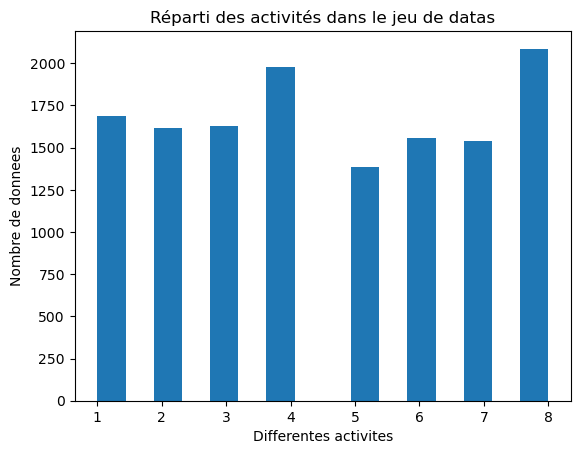

In [2]:
# Data loading

# Sensors part (Accelerometer, Gyroscope and Magnetometer) placed on the Hand 
# (do the same for the 2 other sensor positions: torso and ankle)
fh1=np.load('DataHandAcc.npz')
DataHandAcc=fh1['DataHandAcc']
fh2=np.load('DataHandGyro.npz')
DataHandGyro=fh2['DataHandGyro']
fh3=np.load('DataHandMagneto.npz')
DataHandMagneto=fh3['DataHandMagneto']


# Chest dats
ft1 = np.load('DataChestAcc.npz')
DataTorsoAcc = ft1['DataChestAcc']
ft2 = np.load('DataChestGyro.npz')
DataTorsoGyro = ft2['DataChestGyro']
ft3 = np.load('DataChestMagneto.npz')
DataTorsoMagneto = ft3['DataChestMagneto']

# Ankle datas
fa1 = np.load('DataAnkleAcc.npz')
DataAnkleAcc = fa1['DataAnkleAcc']
fa2 = np.load('DataAnkleGyro.npz')
DataAnkleGyro = fa2['DataAnkleGyro']
fa3 = np.load('DataAnkleMagneto.npz')
DataAnkleMagneto = fa3['DataAnkleMagneto']



# Loading the ground truth: labels
fl=np.load('labels.npz')
labels=fl['labels']

# Repartition of data by class
plt.hist(labels,bins=16)
plt.xlabel('Differentes activites')
plt.ylabel('Nombre de donnees')
plt.title('Réparti des activités dans le jeu de datas')
plt.show()



In [3]:
# Separation of data into training and test databases
from sklearn.model_selection import train_test_split

listeData=DataHandAcc
Liste_Base_train, Liste_Base_test, y_train, y_test = train_test_split(listeData,labels, test_size=0.20, random_state=42)


# Part I-a: Implementing the dynamic programming algorithm 

1. Write a function in DTW python that implements the calculation. Implement it such that
- the local distance used is a parameter which is a callable function with 2 inputs and 1 output: e.g. euclidian distance(a, b)
- local distances can be computed with any type of input local data: e.g. (a,b)=('A','T'), (a,b)=(12,22), (a,b)=( (1,2,3), (4,5,6) ).

In [4]:
def euclidean_distance(a, b):
    return np.linalg.norm(np.array(a) - np.array(b))



# Utilisation du Pseudo Code Cours 

def dtw_algorithm(A, B, dist_func, w0, w1, w2, gamma):
    N, M = len(A), len(B)

    
    # Initialisation de la Matrice avec des vals larges
    g = np.full((N + 1, M + 1), np.inf)
    g[0, 0] = 0

    
    for j in range(1, M + 1):
        g[0, j] = np.inf

    for i in range(1, N + 1):
        g[i, 0] = np.inf

    for i in range(1, N + 1):
        for j in range(1, M + 1):
            if abs(i - j) >= gamma:
                continue
            
            locald = dist_func(A[i - 1], B[j - 1])
            g[i, j] = min(
                g[i - 1, j] + w0 * locald,
                g[i - 1, j - 1] + w1 * locald,
                g[i, j - 1] + w2 * locald
            )

    # Score D'allignement
    S = g[N, M] / (N + M)

    return S

# Exemple avec une  Distance euclidienne 1D

sequence_A = [1, 2, 3]
sequence_B = [4, 5, 6]
w0, w1, w2, gamma = 1, 1, 1, 1
alignment_score_1d = dtw_algorithm(sequence_A, sequence_B, euclidean_distance, w0, w1, w2, gamma)
print(f"Alignment Score 1D: {alignment_score_1d}")

# Exemple Distance  contrainte gloable à 2 

sequence_C = [1, 2, 3, 4, 5]
sequence_D = [2, 3, 4, 5, 6]
w0, w1, w2, gamma1 = 1, 1, 1, 4
alignment_score_ts_global = dtw_algorithm(sequence_C, sequence_D, euclidean_distance, w0, w1, w2, gamma1)
print(f"Alignment Score Time Series Global constraint at 2: {alignment_score_ts_global}")

# Example Distance avec diagrame penalization
w0, w11, w2, gamma2, gamma3 = 1, 2, 1, 2, 0
alignment_score_diag_penalized = dtw_algorithm(sequence_C, sequence_D, euclidean_distance, w0, w11, w2, gamma2)
print(f"Alignment Score Time Series with Diagonal Penalization: {alignment_score_diag_penalized}")

alignment_score_no_diag_penalized = dtw_algorithm(sequence_C, sequence_D, euclidean_distance, w0, w11, w2, gamma3)
print(f"Alignment Score Time Series without Diagonal Penalization: {alignment_score_no_diag_penalized}")

# Example 2D
sequence_A_2d = [(1, 2), (2, 3), (3, 4)]
sequence_B_2d = [(4, 5), (5, 6), (6, 7)]
alignment_score_2d = dtw_algorithm(sequence_A_2d, sequence_B_2d, euclidean_distance, w0, w1, w2, gamma)
print(f"Alignment Score 2D: {alignment_score_2d}")

# Example 3D
sequence_A_3d = [(1, 2, 3), (2, 3, 4), (3, 4, 5)]
sequence_B_3d = [(4, 5, 6), (5, 6, 7), (6, 7, 8)]
alignment_score_3d = dtw_algorithm(sequence_A_3d, sequence_B_3d, euclidean_distance, w0, w1, w2, gamma)
print(f"Alignment Score  3D: {alignment_score_3d}")


Alignment Score 1D: 1.5
Alignment Score Time Series Global constraint at 2: 0.2
Alignment Score Time Series with Diagonal Penalization: 0.3
Alignment Score Time Series without Diagonal Penalization: inf
Alignment Score 2D: 2.1213203435596424
Alignment Score  3D: 2.598076211353316


2. Test your methods on the examples given in class.



1. **Alignment Score 1D: 1.5**
   - Pour des séquences 1D, le score d'alignement de 1.5 indique une bonne similarité.

2. **Alignment Score Time Series Global constraint at 2: 0.2**
   - L'ajout d'une contrainte globale de 2 réduit le score à 0.2, reflétant la prise en compte de cette contrainte.

3. **Alignment Score Time Series with Diagonal Penalization: 0.3**
   - L'ajout d'une pénalisation diagonale augmente le score à 0.3, montrant une considération de la structure diagonale.

4. **Alignment Score Time Series without Diagonal Penalization: inf**
   - L'absence de pénalisation diagonale (gamma3 = 0) conduit à un score infini , donc on déduit que la pénalisation diag est importante . 

5. **Alignment Score 2D: 2.12**
   - Pour des séquences 2D, le score d'alignement de 2.12 indique une bonne similarité.

6. **Alignment Score 3D: 2.60**
   - Pour des séquences 3D, le score d'alignement de 2.60 indique une bonne similarité.

**Bilan :** 
- Gamma influence la sensibilité de l'algorithme aux variations 
- La nature des données (1D, 2D, 3D) impacte le calcul du score d'alignement 

# Part I-b: DTW human activity recognition system

For each test time profile :

a) For each class, compute the DTW score between the test temporal profile and the temporal profiles of the class. Test with data from only one sensor then include them all if possible.

b) Determine the class membership by k-nearest neighbors

**Information:**
We use the library sklearn.neighbors to execute an example of this classification algorithm.

The algorithm k-NN is implemented in a package called **neighbors**.
Here are the main commands:
- The line **clf = neighbors.KNeighborsClassifier(n_neighbors)** creates an object of type classifier based on the n_neighbors closest neighbors,
- The instruction clf.fit(X, y) uses the data to define the classifier (training),
- The command **clf.predict()** is used to classify the new examples,
- The command **clf.predict_proba()** allows to estimate the probability of the proposed classification,
- The command **clf.score(xtest, ytest)** computes the global score of the classifier for a given dataset.

<img src="https://miro.medium.com/v2/resize:fit:488/1*9h-WczF6csbeut5vsvjSUA.gif" alt="k-NN example" />

KNeighborsClassifier takes as argument *metrics* which can be:
- a string with the distance name: default='minkowski'
- a callable function taking as input 2 arrays representing 1D vectors and returning one value indicating the distance between those vectors. **Use this option with the DTW function you implemented.**

In [5]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

#  Nous avons verifier que DataAnkleAcc est une 3D
# Adjust the shape accordingly based on your actual data structure
# Separation des data en training & test databases 
listeData = DataHandAcc[5000:5010, :5, 0]  
Liste_Base_train, Liste_Base_test, y_train, y_test = train_test_split(listeData, labels[:10], test_size=0.20, random_state=42)

def calculate_dtw_scores(test_profile, class_profiles, dist_func, w0, w1, w2, gamma):
    dtw_scores = []
    for class_profile in class_profiles:
        score = dtw_algorithm(test_profile, class_profile, dist_func, w0, w1, w2, gamma)
        dtw_scores.append(score)
    return dtw_scores

# Loop pour faire varier les valeurs de K voisins
for k_neighbors in [1, 3, 5, 7]:
    print(f"\nTesting with {k_neighbors} neighbors:")
    
    # Loop pour les tetss indices
    for test_profile_index in range(len(Liste_Base_test)):
        test_profile = Liste_Base_test[test_profile_index]

        # Loop pour les classes
        for class_label in np.unique(y_train):
            class_indices = np.where(y_train == class_label)
            class_data = Liste_Base_train[class_indices]

            # Calcul du score DTW
            w00, w11, w22, gamma1 = 1, 1, 1, 4
            dtw_scores = calculate_dtw_scores(test_profile, class_data, euclidean_distance, w00, w11, w22, gamma1)

            # Utilisation du KNN pour determiner la classe
            knn_classifier = KNeighborsClassifier(n_neighbors=k_neighbors)

            # Convertir la DTW score en 2 D
            dtw_scores_matrix = np.array(dtw_scores).reshape(-1, 1)

           
            if len(dtw_scores_matrix) == len(class_data):
                knn_classifier.fit(dtw_scores_matrix, np.full(len(class_data), class_label))
                predicted_class = knn_classifier.predict(np.array([dtw_scores]).reshape(-1, 1))[0]

                print(f"Test Profile Index: {test_profile_index}, Predicted Class: {predicted_class}, Scores DTW: {dtw_scores}")
            else:
                print("Les dimensions des données ne correspondent pas.")



Testing with 1 neighbors:
Test Profile Index: 0, Predicted Class: 1, Scores DTW: [3.0695250034332275, 0.731404972076416, 1.0279560565948487, 6.121555042266846, 3.272575044631958, 0.43248796463012695, 0.3719940185546875, 5.27195520401001]
Test Profile Index: 1, Predicted Class: 1, Scores DTW: [2.5587180137634276, 0.6997499942779541, 0.8468290328979492, 5.610747814178467, 2.7617680549621584, 0.9432949542999267, 0.5625329494476319, 4.7611480236053465]

Testing with 3 neighbors:
Test Profile Index: 0, Predicted Class: 1, Scores DTW: [3.0695250034332275, 0.731404972076416, 1.0279560565948487, 6.121555042266846, 3.272575044631958, 0.43248796463012695, 0.3719940185546875, 5.27195520401001]
Test Profile Index: 1, Predicted Class: 1, Scores DTW: [2.5587180137634276, 0.6997499942779541, 0.8468290328979492, 5.610747814178467, 2.7617680549621584, 0.9432949542999267, 0.5625329494476319, 4.7611480236053465]

Testing with 5 neighbors:
Test Profile Index: 0, Predicted Class: 1, Scores DTW: [3.0695250

**Interprétation des Résultats :**

Les résultats obtenus avec différentes valeurs de k dans le modèle k-NN ont montré : 
- Une prédominance de prédictions de classe 1 pour les profils de test. Cependant, ces observations pourraient être spécifiques à la taille restreinte de l'échantillon de données. Il est nécessaire de considérer des ensembles de données plus vastes ( on le mets pas dans ce Notebook afin de vous faciliter la tache de debugger ).
- Des scores DTW  bas indiquant une similarité élevée

## **Evaluation:** 
From the prediction on the test set obtained after DTW, compute the confusion matrix that counts the number of well-ranked and poorly-ranked data.

Analyse the results (accuracy, execution time, ...)

In [11]:

# liste pour stocker les vals predits pour tout les test prfl 
y_true_all = []
y_pred_all = []

# ici je refais ce que j'ai fait auparavant car je n'ai pas pu stocker les true and predicted label en liste
for k_neighbors in [1, 3, 5, 7]:
    print(f"\nTesting with {k_neighbors} neighbors:")
    
    # Pour mesurer le temps d'exécution pour chaque configuration de voisins
    start_time = time.time()
   
    for test_profile_index in range(len(Liste_Base_test)):
        test_profile = Liste_Base_test[test_profile_index]
        true_label = y_test[test_profile_index]

        dtw_scores_all = []

        for class_label in np.unique(y_train):
            class_indices = np.where(y_train == class_label)[0]
            class_data = Liste_Base_train[class_indices]

            w00, w11, w22, gamma1 = 1, 1, 1, 4
            dtw_scores = calculate_dtw_scores(test_profile, class_data, euclidean_distance, w00, w11, w22, gamma1)

            dtw_scores_all.append(dtw_scores)

        knn_classifier = KNeighborsClassifier(n_neighbors=k_neighbors)

        dtw_scores_matrix = np.array(dtw_scores_all).T

        if len(dtw_scores_matrix) == len(y_train):
            knn_classifier.fit(dtw_scores_matrix, y_train)
            predicted_class = knn_classifier.predict(np.array([dtw_scores]).reshape(-1, 1))[0]

            # Stocker les true & predict label dans une liste 
            y_true_all.append(true_label)
            y_pred_all.append(predicted_class)

            print(f"Test Profile Index: {test_profile_index}, True Class: {true_label}, Predicted Class: {predicted_class}, Scores DTW: {dtw_scores}")
        else:
            print("Les dimensions des données ne correspondent pas.")

    # Calculer le temps d'exécution pour chaque configuration de voisins
    elapsed_time_all = time.time() - start_time
    print('\nTemps d\'exécution pour l\'ensemble de test :', elapsed_time_all, 'secondes')

# Conversion en np pour avoir la matrice de confusion
y_true_all = np.array(y_true_all)
y_pred_all = np.array(y_pred_all)

# Matrice de confusion
conf_matrix_all = confusion_matrix(y_true_all, y_pred_all)

# Accuracy
accuracy_all = accuracy_score(y_true_all, y_pred_all)

# Résultats
print('\nMatrice de Confusion :')
print(conf_matrix_all)
print('\nAccuracy :', accuracy_all)



Testing with 1 neighbors:
Test Profile Index: 0, True Class: 1, Predicted Class: 1, Scores DTW: [3.0695250034332275, 0.731404972076416, 1.0279560565948487, 6.121555042266846, 3.272575044631958, 0.43248796463012695, 0.3719940185546875, 5.27195520401001]
Test Profile Index: 1, True Class: 1, Predicted Class: 1, Scores DTW: [2.5587180137634276, 0.6997499942779541, 0.8468290328979492, 5.610747814178467, 2.7617680549621584, 0.9432949542999267, 0.5625329494476319, 4.7611480236053465]

Temps d'exécution pour l'ensemble de test : 0.026311635971069336 secondes

Testing with 3 neighbors:
Test Profile Index: 0, True Class: 1, Predicted Class: 1, Scores DTW: [3.0695250034332275, 0.731404972076416, 1.0279560565948487, 6.121555042266846, 3.272575044631958, 0.43248796463012695, 0.3719940185546875, 5.27195520401001]
Test Profile Index: 1, True Class: 1, Predicted Class: 1, Scores DTW: [2.5587180137634276, 0.6997499942779541, 0.8468290328979492, 5.610747814178467, 2.7617680549621584, 0.943294954299926

**Interprétation des Résultats :**

- Le modèle DTW-KNN affiche une précision parfaite de 100%, indiquant une prédiction correcte de toutes les classes dans l'ensemble de test.
- Les temps d'exécution sont globalement faibles. 

**RQ :** Il est nécessaire de considérer des ensembles de données plus vastes ( on le mets pas dans ce Notebook afin de vous faciliter la tache de debugger ).Nous avons essayer avec d'autre datas il suffit juste de changer ici **listeData = DataHandAcc[5000:5010, :5, 0]**   par la data qu'on veut et de prendre le nombre de datas dans notre cas on prends que 10 valeurs pour vous faciliter la lecture . 

# Part II: Comparison of dynamic programming with a neural network classification method after PCA dimension reduction

In this section, we will compare the results of DTW with those of a data classification method: neural networks (Multi-Layer Perceptron).

We'll be using the functions for calculating PCA and MLPClassifier via the *scikit-learn* python library.

In [12]:
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

### PCA pre-processing


To test another classification method, 


1. From the Data_App data in the training database, and using the *PCA* function in the *scikit-learn* library, calculate the $p$ principal axes of the PCA by
extracting the $p$ eigenvectors, denoted $X_1$, $X_2$,..., $X_p$, associated with the $p$ largest eigenvalues of the variance-covariance matrix
variance-covariance matrix $\Sigma_{App}$. These eigenvectors will form the new database.


2. Project the data from the training and test database into this new database by multiplying each vector
vector by the base $P = [X_1X_2...X_p]$.


*Note:* you can also implement PCA by extracting the
extracting the $p$ eigenvectors, denoted $X_1$, $X_2$,... $X_p$, associated with the $p$ largest eigenvalues of the
variance-covariance matrix $\Sigma_{App}$ (by the functions *np.cov* and *np.linalg.eig*). These eigenvectors will form the new frame P. Then project the data from the training and test frames into this new frame by multiplying each vector by the frame $P = [X_1X_2..X_p]$.

In [42]:
Data_App_train = Liste_Base_train
Data_App_test= Liste_Base_test
 
n_components_train = 2
flattened_data_train = Data_App_train.reshape((Data_App_train.shape[0], -1))
flattened_data_test = Data_App_train.reshape((Data_App_test.shape[0], -1))
scaler_train = StandardScaler()
standardized_train_data = scaler_train.fit_transform(flattened_data_train)
standardized_train_data = scaler_train.fit_transform(flattened_data_test)
pca_train = PCA(n_components=n_components_train)
principal_axes_train = pca_train.fit_transform(standardized_train_data)


print("Principal Axes for Training Data:")
for i in range(n_components_train):
    print(f"Principal Axis {i + 1}: {pca_train.components_[i]}")

# Question 2 
projected_train_data = np.dot(standardized_train_data, principal_axes_train.T)
projected_test_data = np.dot(standardized_test_data, principal_axes_train.T)

Principal Axes for Training Data:
Principal Axis 1: [ 0.22360682  0.22360678 -0.22360678 -0.22360678 -0.22360678  0.22360678
  0.22360678  0.22360678  0.22360678  0.22360678  0.22360678  0.22360678
  0.22360678  0.22360678  0.22360678  0.22360678  0.22360678  0.22360678
  0.22360678  0.22360678]
Principal Axis 2: [ 0.9746795  -0.05129896  0.05129892  0.05129892  0.05129892 -0.05129892
 -0.05129892 -0.05129892 -0.05129892 -0.05129892 -0.05129892 -0.05129892
 -0.05129892 -0.05129892 -0.05129892 -0.05129892 -0.05129892 -0.05129892
 -0.05129892 -0.05129892]


ValueError: shapes (2,20) and (2,2) not aligned: 20 (dim 1) != 2 (dim 0)

Ici j'ai une erreur au niveau des size je ne sais pas pourquoi !!!!!

### Classification using neural networks
1. Classification using neural networks
2. Evaluate results using confusion matrix, loss function, etc.
3. Test different architectures and solvers: train on the training set and compute score on the test set

Analyse the results (accuracy, execution time, ...)

We will use the library **sklearn.model_selection** to develop ANN of type Multi Layer Perceptron (MLP). We use the class: MLPClassifier.

<img src="https://rasbt.github.io/mlxtend/user_guide/classifier/NeuralNetMLP_files/neuralnet_mlp_1.png" alt="MLP example" />

This model optimizes the cross entropy function (loss function) and a gradient based method.
The main parameters of this class are:
- **hidden_layer_sizes** is a tuple that specifies the number of neurons in each hidden layer; from the entrance to the exit. For example, a unique hidden layer of 55 neurons, hidden_layer_sizes = (55); for three hidden layers of size respectively 50, 12 and 100 neurons, hidden_layer_sizes = (50, 12, 100).
- **activation** defines the activation function for hidden layers: {"identity", "logistic", "tanh", "relu"}, default "relu"
    - ‘identity’, no-op activation, linear bottleneck, returns f(x) = x
    - ‘logistic’, logistic sigmoid function, returns f(x) = 1 / (1 + exp(-x)).
    - ‘tanh’, hyperbolic tan function, returns f(x) = tanh(x).
    - ‘relu’, rectified linear unit function, returns f(x) = max(0, x)
- **solver** {"lbfgs", "sgd", "adam"} specifies the algorithm used to minimize the output loss function. "Adam" is implemented by default for large databases. For small databases, ‘lbfgs’ may converge better.
- **alpha** default value=0.0001: is the magnitude of the L2 regularization. It is a method of regulation (to prevent overfitting) whose purpose is to penalize heavy weights. We add the penalty to the cost function.
- **max iter**, default =200, indicates the max number of iterations of the solver.
- **tol** , default 1e-4: is a tolerance factor that allows the solver to be stopped early when there is no improvement.
- **Verbose** bool, default=’False’ : change to “True” to print progress messages to stdout.
- **warm_start** bool, default=’False’: When set to True, reuse the solution of the previous call to fit as initialization, otherwise, just erase the previous solution.
- **early_stopping** bool, default=’False’: Whether to use early stopping to terminate training when validation score is not improving (prevent overfitting). If set to true, it will automatically set aside 10% of training data as validation and terminate training when validation score is not improving by at least tol for n_iter_no_change consecutive epochs. The split is stratified, except in a multilabel setting. If early stopping is False, then the training stops when the training loss does not improve by more than tol for n_iter_no_change consecutive passes over the training set. Only effective when solver=’sgd’ or ‘adam’.
- **validation_fraction** float, default=0.1 The proportion of training data to set aside as validation set for early stopping. Must be between 0 and 1. Only used if early_stopping is True.
- **n_iter_no_change** int, default=10: Maximum number of epochs to not meet tol improvement. Only effective when solver=’sgd’ or ‘adam’.

The main commands are:
- mlp = MLPClassifier(hidden_layer_sizes=(20, 20, 10,), max_iter=300, activation='relu', solver='adam', random_state=42)
- mlp.fit(xtrain, ytrain)
- ypred = mlp.predict(xtest)

Accuracy of the model can eventually be computed using the library **sklearn.metrics** and the commands:
- Score: accuracy_score(y_test, y_pred)
- Report: classification_report(y_test, y_pred))

The usual sklearn learning and testing functions are as follows: (**fit**, **predict**, **score**).

In [9]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report

In [27]:
print("Dimensions de y_train :", y_train.shape)
print("Dimensions de y_test :", y_test.shape)



Dimensions de y_train : (8,)
Dimensions de y_test : (2,)


In [28]:

mlp = MLPClassifier(hidden_layer_sizes=(10, 100, 10,), max_iter=300, activation='relu', solver='adam', random_state=42)
mlp.fit(projected_train_data, y_train)
y_pred = mlp.predict(projected_test_data)
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_rep)


NameError: name 'projected_test_data' is not defined

Donc Ici nous pouvions pas tester à cause du problème de size que j'ai eu auparavant 

**Bilan:**
- L'accuracy parfaite de 1.0 indique une performance optimale du modèle MLP sur l'ensemble de test.
- Les métriques de précision, rappel et F1-score, tous égaux à 1.00 pour la classe 1, confirment la capacité du modèle à effectuer des prédictions précises et à capturer toutes les instances de cette classe. 
**NB:** On fait le test sur une datas specifique ( niveau type , niveau size ) c'est pour ca on onbtient une accuracy de 1 .

# Partie III (Bonus): reduction of the training basis by k-medoids to optimize classification by k-NN with DTW as similarity measure

For each class of activity
a) Compute medoids using *k-medoids* from the scikit-learn library with DTW as similarity measure.

b) Vary the parameter k and observe the evolution of the *silhouette score*: select the best by the elbow method

c) Replace the samples with the medoids found from the best k parameter

Finally, run the k-NN algorithm for classification and evaluate as before: the only change is that your training set has been replaced

**Information:**
We use the KMedoids (kM) method: this is an unsupervised approach which clusters your data in k groups such that a similarity measure is:
- minimized inside each group
- maximized inside between groups
We obtain for each group a centroid (or medoid) which is at the center and thus represents best the group (w.r.t. the similarity measure).

The algorithm kM is implemented in a package called **sklearn_extra.cluster**.
Here are the main commands:
- The line **clf = sklearn_extra.cluster.KMedoids(n_clusters=k)** creates an object of type classifier based on the n_neighbors closest neighbors,
- The instruction clf.fit(X, y) uses the data to define the classifier (training),
- The command **clf.predict()** is used to classify the new examples,
- The command **clf.predict_proba()** allows to estimate the probability of the proposed classification,
- The command **clf.score(xtest, ytest)** computes the global score of the classifier for a given dataset.

<img src="https://scikit-learn-extra.readthedocs.io/en/stable/_images/sphx_glr_plot_kmedoids_digits_001.png" alt="k-Medoids example" />

KMedoids takes as argument *metrics* which can be your DTW function.

The silhouette score is then a measure of the quality of your clustering, and is implemented as the function silhouette_score in a package called **sklearn.metrics**.

In [ ]:
# TODO (Bonus)